In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import scipy.stats as stats

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

import explore
import acquire

## Acquire data frame from two csv files

In [2]:
emotify_plus_df = acquire.new_data()

## Prepare and clean data prior to splitting into train, validate and test

In [3]:
df1 = acquire.prep_data(emotify_plus_df)

In [4]:
#sanity check
df1.head(1).T

,0
track_id,1
genre_x,classical
mood,3
age,21
gender,1
key,Dbm
minor_key,1
tempo,medium
liked,1
disliked,0


In [5]:
#sanity check
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8407 entries, 0 to 8406
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   track_id      8407 non-null   int64   
 1   genre_x       8407 non-null   object  
 2   mood          8407 non-null   int64   
 3   age           8407 non-null   int64   
 4   gender        8407 non-null   int64   
 5   key           8407 non-null   object  
 6   minor_key     8407 non-null   int64   
 7   tempo         8407 non-null   category
 8   liked         8407 non-null   int64   
 9   disliked      8407 non-null   int64   
 10  feel_sublime  8407 non-null   int64   
 11  agitated      8407 non-null   int64   
 12  energized     8407 non-null   int64   
 13  electronic    8407 non-null   uint8   
 14  pop           8407 non-null   uint8   
 15  rock          8407 non-null   uint8   
 16  medium        8407 non-null   uint8   
 17  fast          8407 non-null   uint8   
 18  very_fas

## Split data into train, validate and test
### Target for first iteration will be energized

In [6]:
target = 'energized'
df = df1
train, validate, test = explore.train_validate_test_split(df, target, seed=123)

In [7]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (4707, 19)
validate -> (2018, 19)
test -> (1682, 19)


In [8]:
#sanity check, visualize one row of train
train.head(1)

,track_id,genre_x,mood,age,gender,key,minor_key,tempo,liked,disliked,feel_sublime,agitated,energized,electronic,pop,rock,medium,fast,very_fast
3845,139,rock,4,62,0,Abm,1,fast,1,0,0,1,1,0,0,1,0,1,0


## Exploratory Data Analysis

### Visualize features and some prelimary investigating of feature relationships


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4707 entries, 3845 to 3653
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   track_id      4707 non-null   int64   
 1   genre_x       4707 non-null   object  
 2   mood          4707 non-null   int64   
 3   age           4707 non-null   int64   
 4   gender        4707 non-null   int64   
 5   key           4707 non-null   object  
 6   minor_key     4707 non-null   int64   
 7   tempo         4707 non-null   category
 8   liked         4707 non-null   int64   
 9   disliked      4707 non-null   int64   
 10  feel_sublime  4707 non-null   int64   
 11  agitated      4707 non-null   int64   
 12  energized     4707 non-null   int64   
 13  electronic    4707 non-null   uint8   
 14  pop           4707 non-null   uint8   
 15  rock          4707 non-null   uint8   
 16  medium        4707 non-null   uint8   
 17  fast          4707 non-null   uint8   
 18  very_

In [10]:
cat_vars = ['genre_x', 'mood', 'gender', 'key', 'minor_key', 'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
quant_vars = ['track_id', 'age']
cat_var = ['genre_x', 'mood', 'gender', 'key', 'minor_key', 'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
quant_var = ['track_id', 'age']

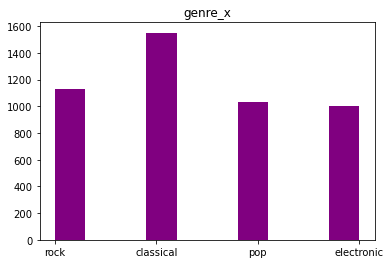

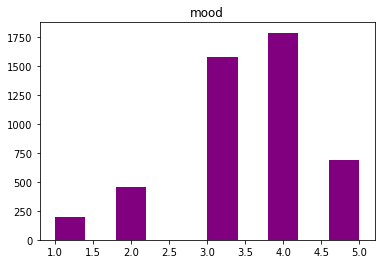

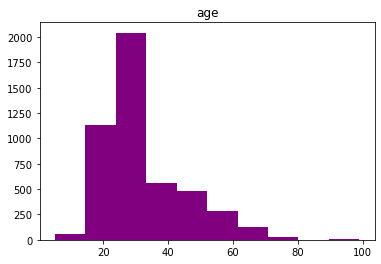

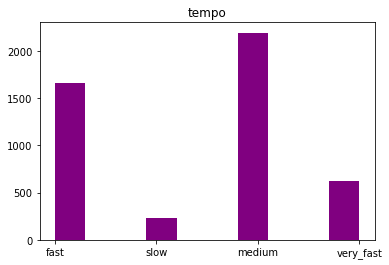

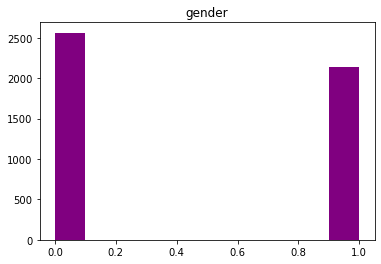

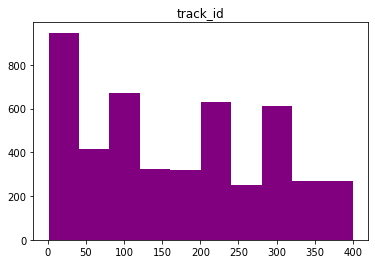

In [14]:
cols = ['genre_x', 'mood', 'age', 'tempo', 'gender', 'track_id']
for col in cols:
    plt.hist(train[col], color='purple')
    plt.title(col)
    plt.show()

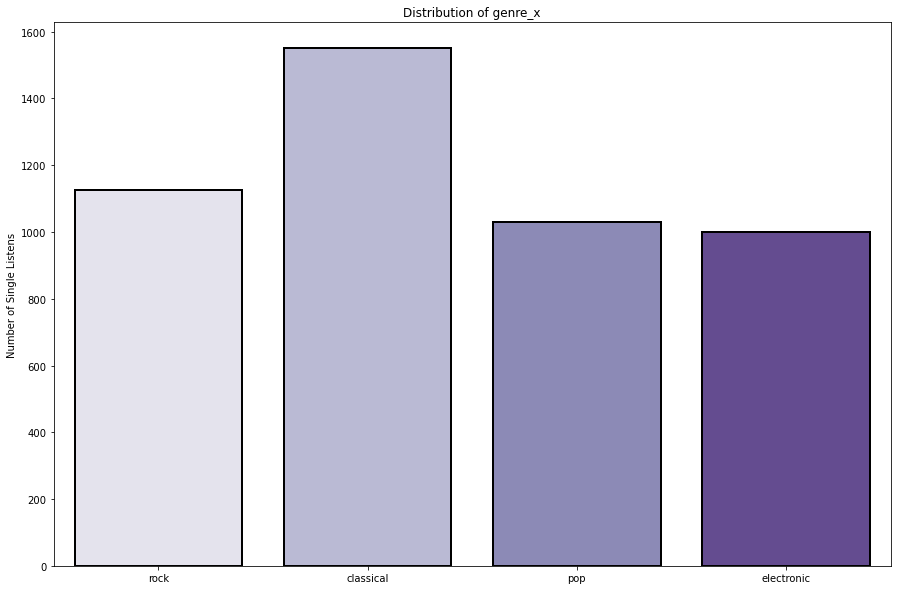

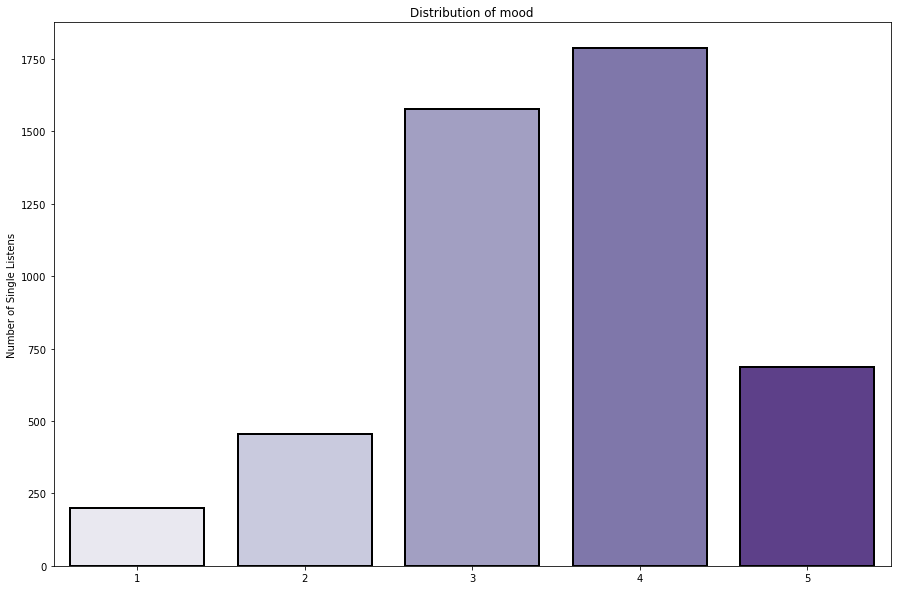

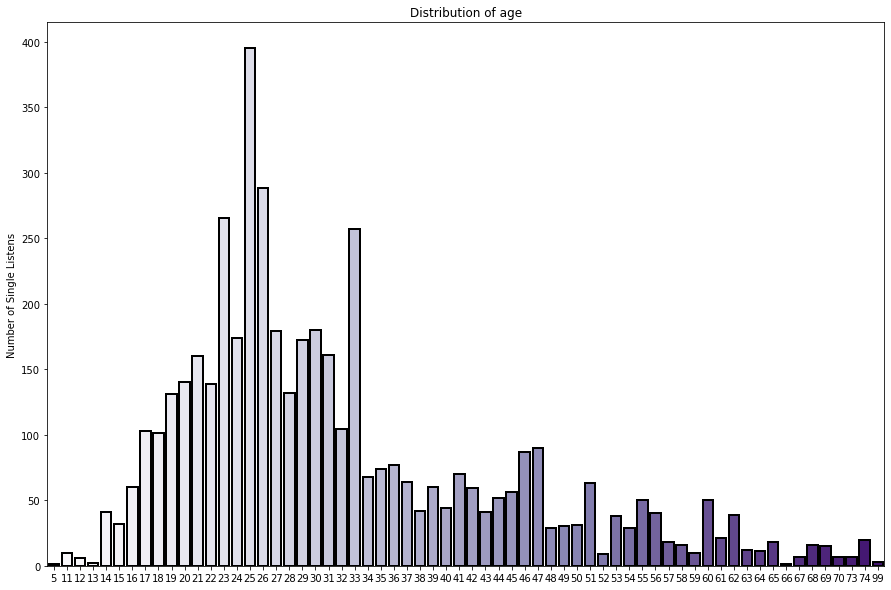

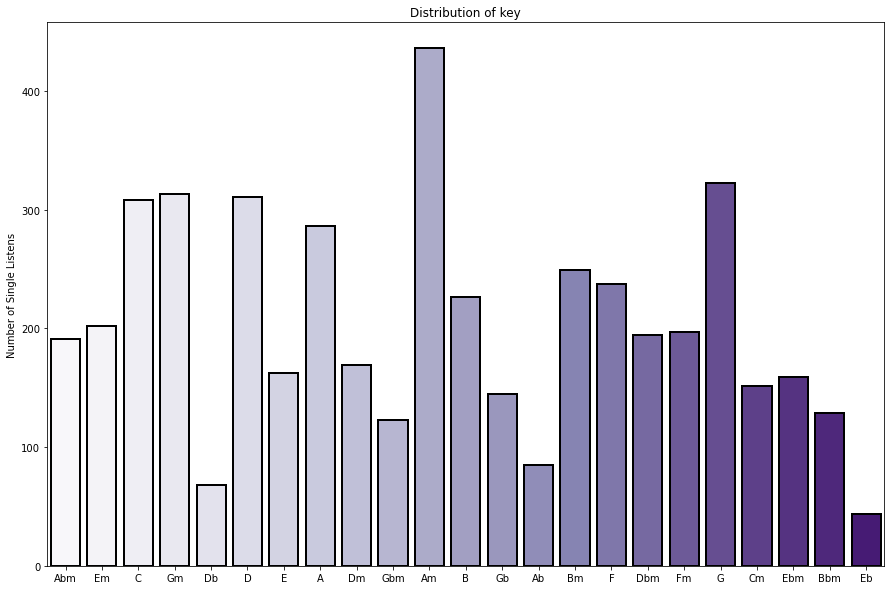

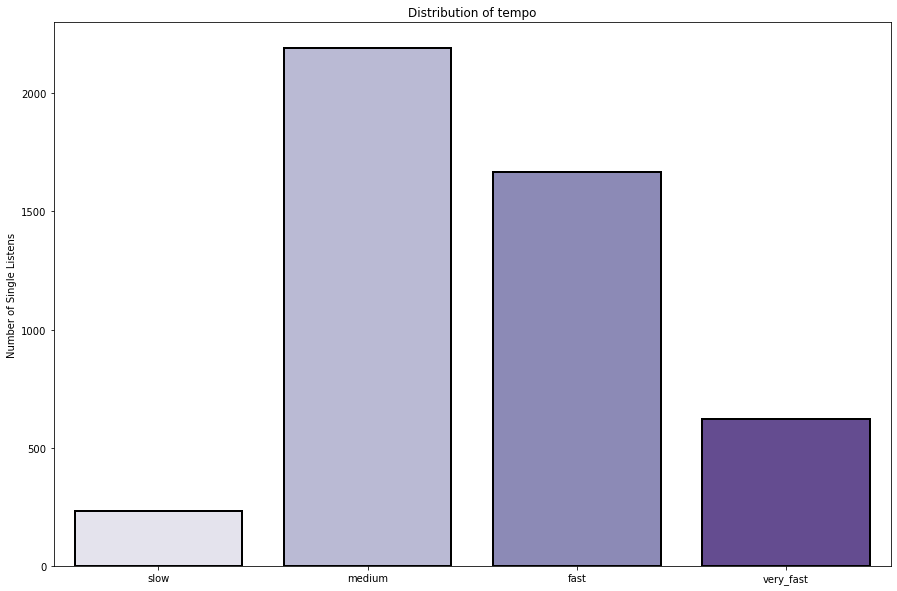

In [15]:

cols = ['genre_x', 'mood', 'age', 'key', 'tempo']

for col in cols:
    plt.figure(figsize=(15,10))
    sns.countplot(x = col, data=train, palette='Purples', ec='black', linewidth=2)

    plt.title('Distribution of ' + col)
    plt.xlabel('')
    plt.ylabel('Number of Single Listens')

    plt.show()

<AxesSubplot:>

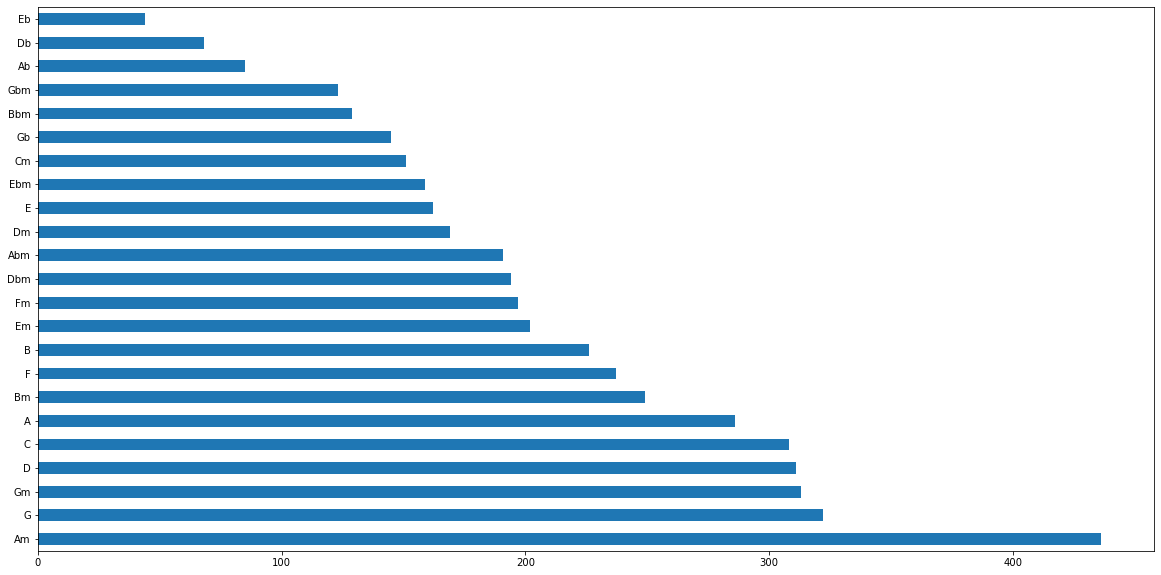

In [16]:
train['key'].value_counts().plot(kind='barh', figsize=(20,10))

<AxesSubplot:>

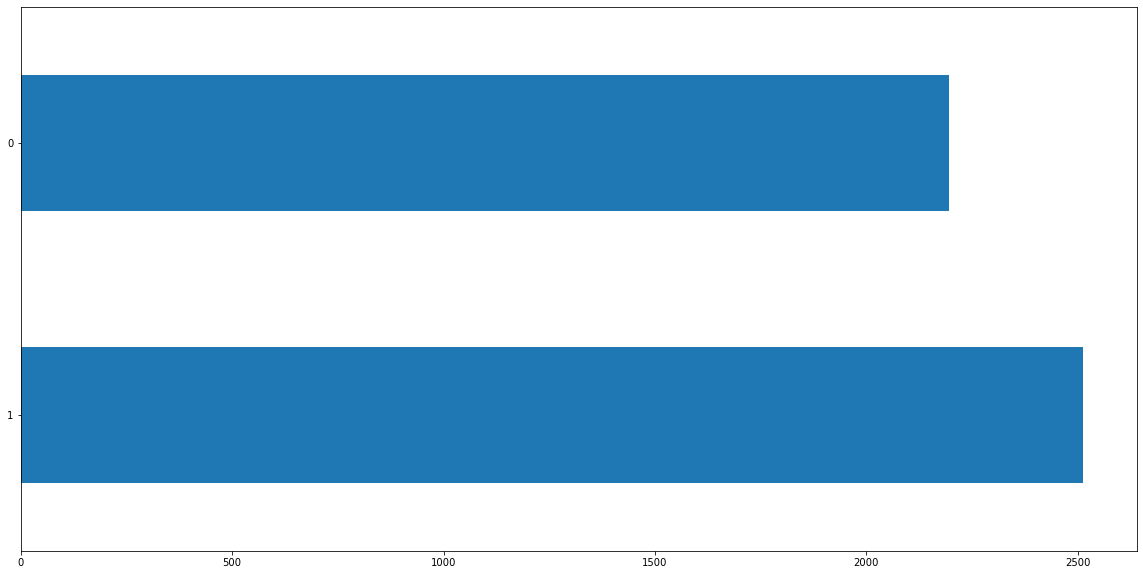

In [17]:
train['minor_key'].value_counts().plot(kind='barh', figsize=(20,10))

### Takeaways from visualizing simple distributions:
    - Nothing is really that normal: genre_x, mood and age are somewhat normal in shape
    - The songs are unfamiliar, yet there are songs that were listened to more often than others.
        - Tracks 1-35, 75-110, 205-240, 280-320 look like they got more listens.
    - Gender is likely not a driving factor since they are about evenly distributed
    - Most songs are in the key of A minor
    - Most songs are a medium to fast tempo
    - Most listeners are in a okay(3) to good(4) mood.
    - Most listens were of classical music, although not by that much. 
    - The fewest listens were of electronic music.

In [18]:
train.describe()

,track_id,mood,age,gender,minor_key,liked,disliked,feel_sublime,agitated,energized,electronic,pop,rock,medium,fast,very_fast
count,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.00000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000
mean,169.165498,3.489696,32.019333,0.455492,0.533886,0.391120,0.205651,0.706607,0.36690,0.369025,0.212237,0.219035,0.239218,0.465477,0.353728,0.131719
std,117.142080,0.995768,12.507586,0.498068,0.498903,0.488053,0.404220,0.455365,0.48201,0.482592,0.408935,0.413637,0.426652,0.498860,0.478177,0.338221
min,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,3.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,160.000000,4.000000,28.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,275.000000,4.000000,38.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,400.000000,5.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


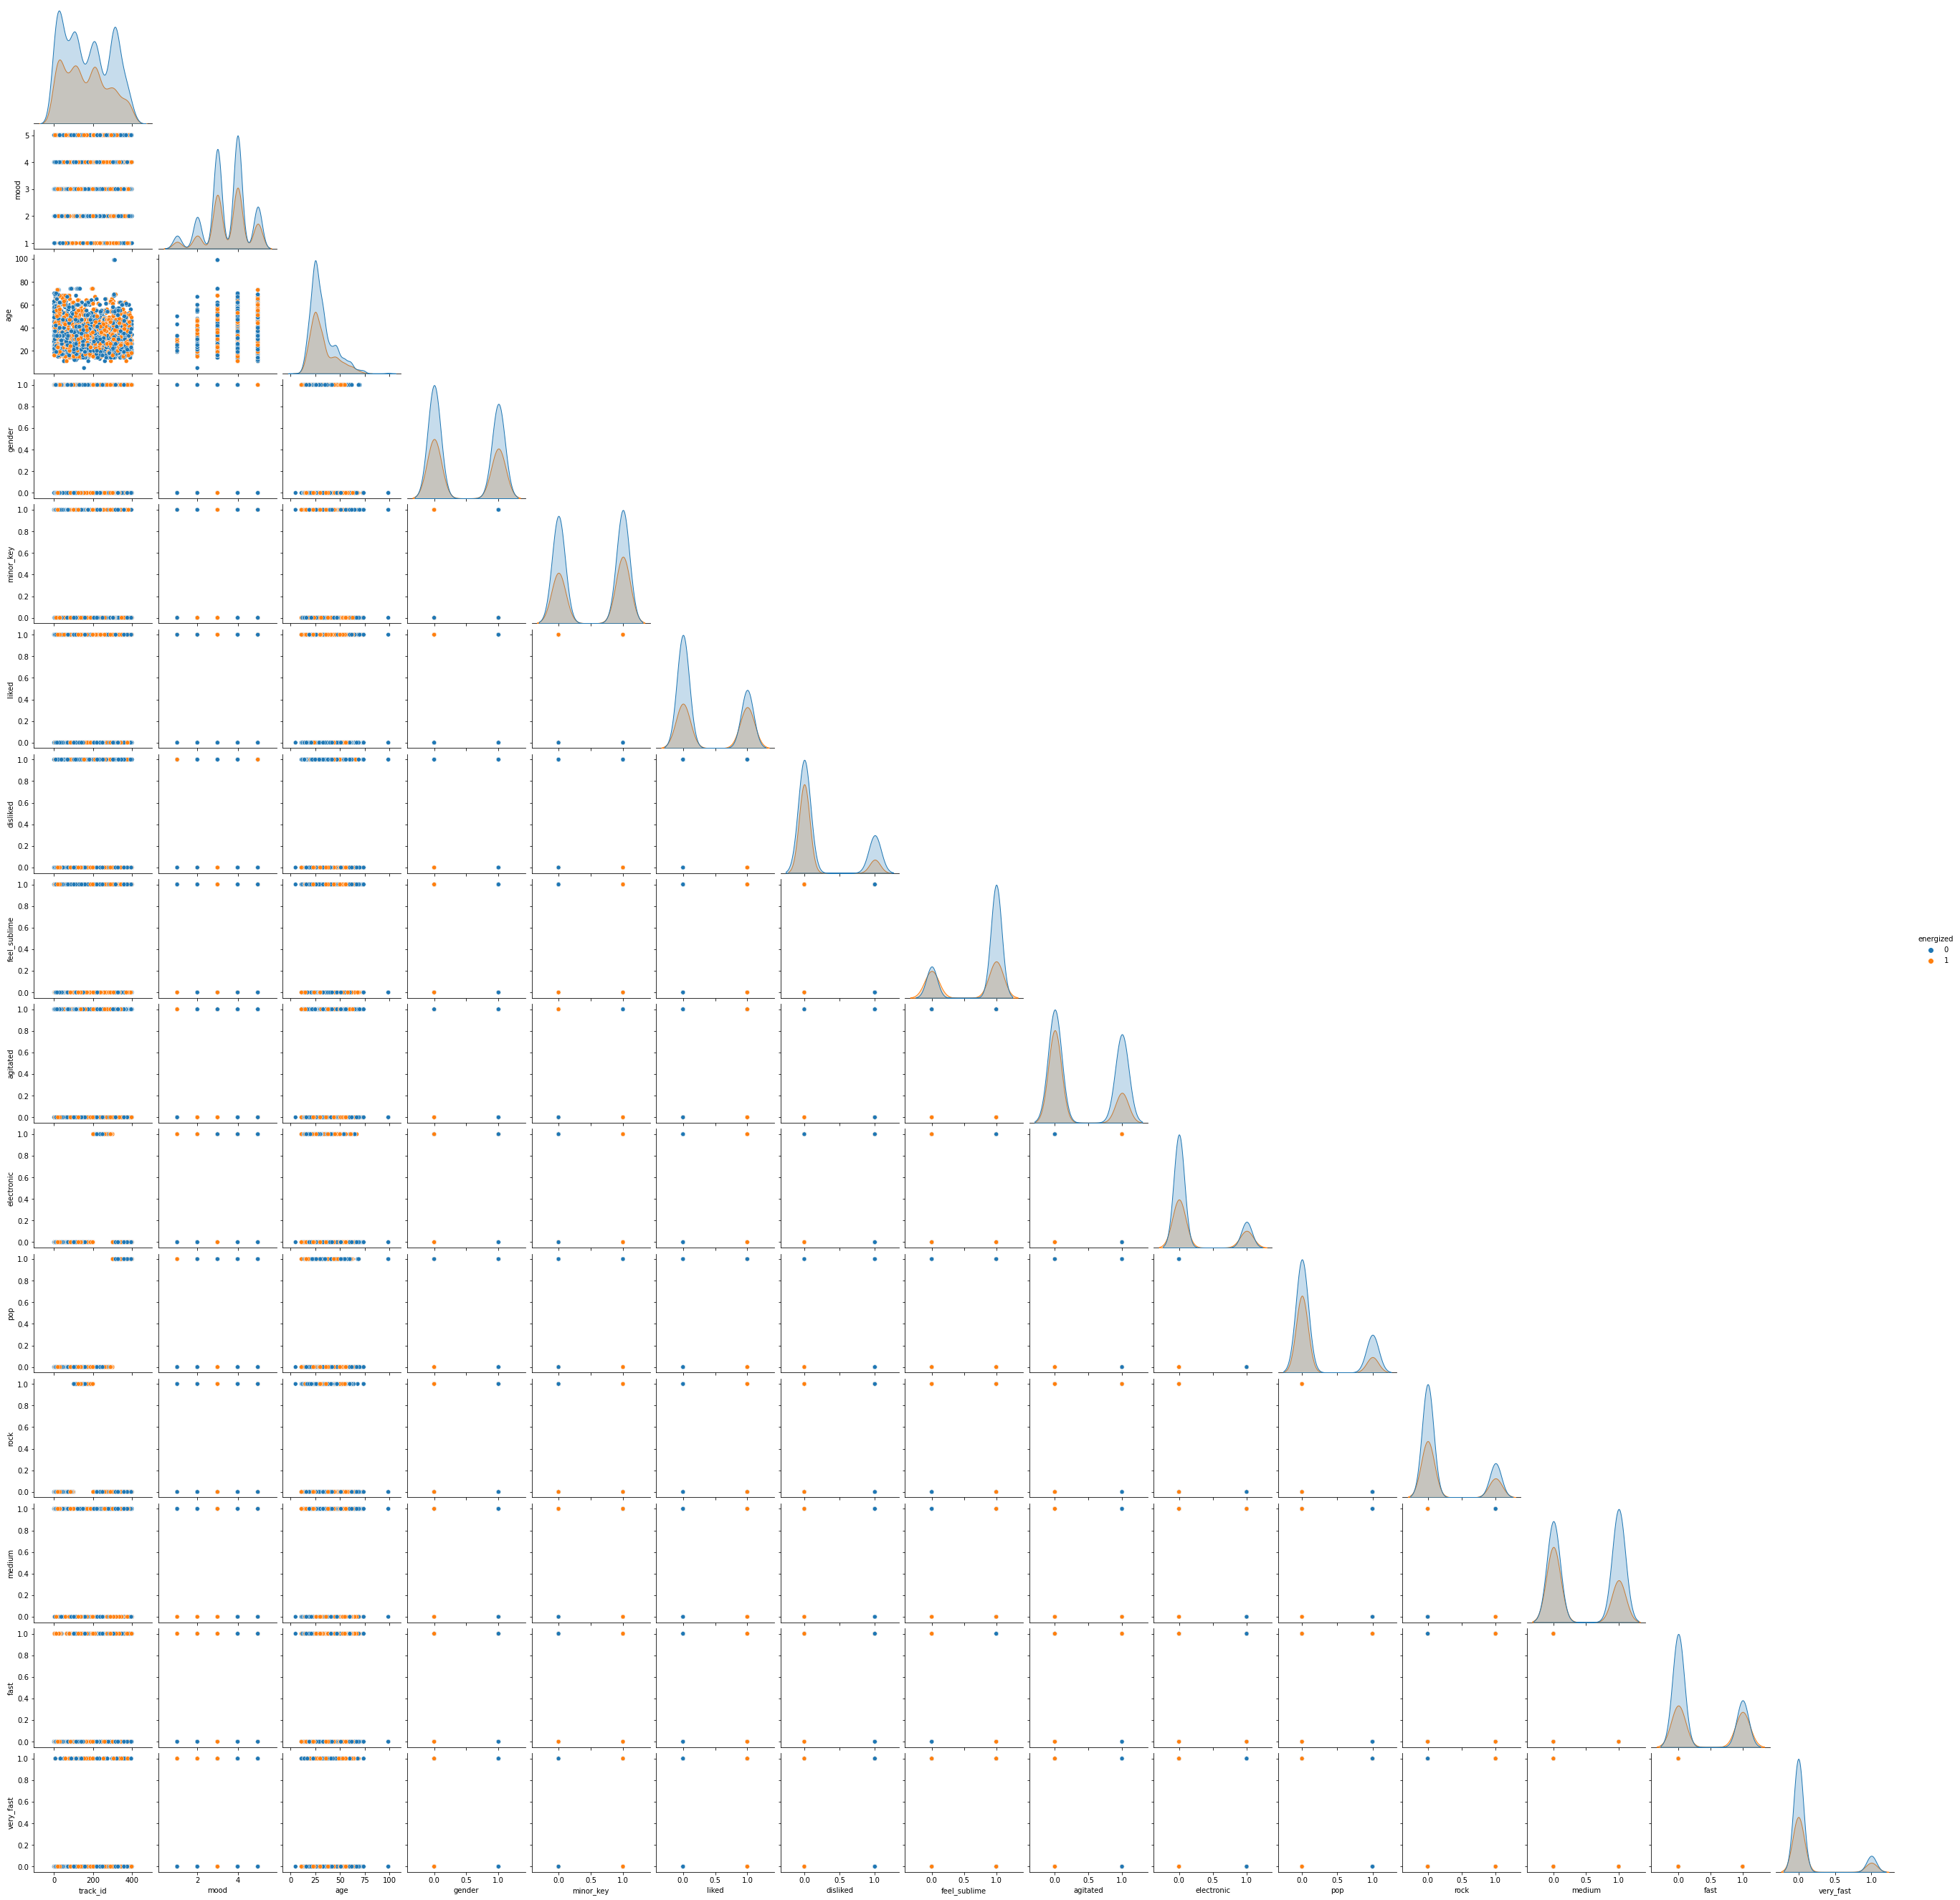

In [19]:
sns.pairplot(data=train, corner=True, hue='energized')

plt.show()

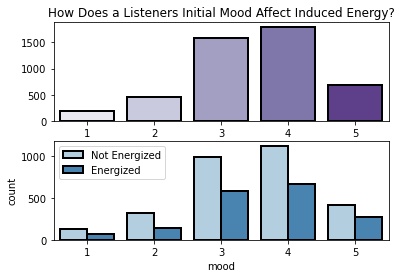

In [22]:
plt.subplot(211)

sns.countplot(x = 'mood', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Listeners Initial Mood Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')

plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'mood', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

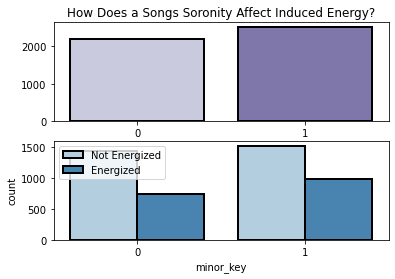

In [28]:
plt.subplot(211)

sns.countplot(x = 'minor_key', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Soronity Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'minor_key', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

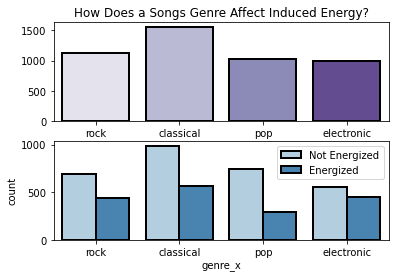

In [29]:
plt.subplot(211)

sns.countplot(x = 'genre_x', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Genre Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'genre_x', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

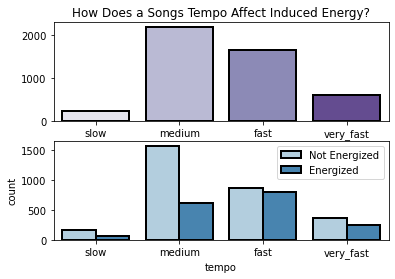

In [30]:
plt.subplot(211)

sns.countplot(x = 'tempo', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Tempo Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'tempo', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

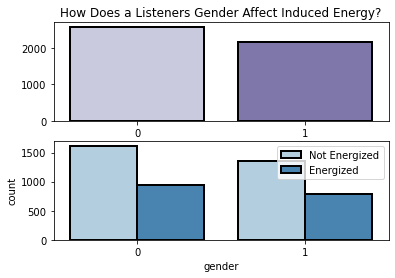

In [31]:
plt.subplot(211)

sns.countplot(x = 'gender', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Listeners Gender Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'gender', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

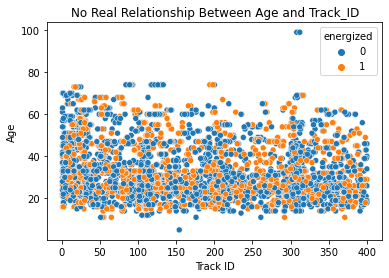

In [34]:
sns.scatterplot(x='track_id', y='age', data=train, hue='energized')
plt.title('No Real Relationship Between Age and Track_ID')
plt.xlabel('Track ID')
plt.ylabel('Age')

plt.show()

In [35]:
train.columns

Index(['track_id', 'genre_x', 'mood', 'age', 'gender', 'key', 'minor_key',
       'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated', 'energized',
       'electronic', 'pop', 'rock', 'medium', 'fast', 'very_fast'],
      dtype='object')

In [43]:
cat_var = ['genre_x', 'mood', 'gender', 'key', 'minor_key',
       'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
quant_var = ['track_id', 'age']

In [45]:
#explore.run_chi2(train, cat_var, target)

In [47]:
#chi2_summary, observed, expected = run_chi2(train, cat_var, target)

In [49]:
#p = plot_cat_by_target(train, target, cat_var)

In [58]:
train.energized.value_counts(normalize=True)

0    0.630975
1    0.369025
Name: energized, dtype: float64

## Baseline accuracy of 63% that listeners were not energized while listening to unfamiliar music.

In [51]:
train.columns

Index(['track_id', 'genre_x', 'mood', 'age', 'gender', 'key', 'minor_key',
       'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated', 'energized',
       'electronic', 'pop', 'rock', 'medium', 'fast', 'very_fast'],
      dtype='object')

In [52]:
# I will drop any remaining categorical features I have left.

X_train = train.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_train = train[['energized']]

X_validate = validate.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_validate = validate[['energized']]

X_test = test.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_test = test[['energized']]

In [53]:
X_train.head(1)

,track_id,mood,age,gender,minor_key,liked,disliked,feel_sublime,agitated,electronic,pop,rock,medium,fast,very_fast
3845,139,4,62,0,1,1,0,0,1,0,0,1,0,1,0


In [54]:
# This is my target variable, my label.

y_train.head(1)

,energized
3845,1


In [57]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)

In [59]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [60]:
# Create a list of our model features.

features = X_train.columns.tolist()

In [61]:
# Create a list of the weights for each feature from our model.

weights = logit.coef_.flatten()

In [62]:
# Store our lists from above in a DataFrame.

pd.DataFrame(weights, features).reset_index().rename(columns={'index': 'feature', 0: 'weight'})

,feature,weight
0,track_id,0.000309
1,mood,0.106895
2,age,-0.001488
3,gender,0.112963
4,minor_key,0.182108
5,liked,0.477386
6,disliked,-0.982259
7,feel_sublime,-1.786987
8,agitated,-1.440066
9,electronic,0.081354


In [63]:
# Create eval_df and rename the train survived column actual.
train_eval_df = train[['energized']].rename(columns={'energized': 'actual'})

# Add your baseline predictions.
train_eval_df['baseline'] = 0

# Predict whether a listener will be energized using the X_train data; add column to eval_df
train_eval_df['LR1_predicted'] = logit.predict(X_train)

# Estimate the probability of a listener being energized using the X_train data; add col to eval_df

train_eval_df['LR1_proba'] = logit.predict_proba(X_train)[:, 1]

train_eval_df.head()

,actual,baseline,LR1_predicted,LR1_proba
3845,1,0,1,0.673094
1152,1,0,1,0.527393
3639,0,0,0,0.170928
6911,0,0,0,0.175103
6219,0,0,0,0.330393


In [64]:
# Get our accuracy score for our logistic regression model.

logit.score(X_train, y_train)

0.7312513278096452

In [65]:
recall_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.88350168, 0.47092689])

In [66]:
precision_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.7406153 , 0.70274914])

In [67]:
pd.crosstab(index=train_eval_df.actual, 
            columns=train_eval_df.LR1_predicted, 
            rownames=['Actual'], 
            colnames=['Predicted'])

Predicted,0,1
Actual,,
0,2624,346
1,919,818


In [ ]:
# My LR model is beating my baseline accuracy at predicting my target value, survived.

print(classification_report(y_true=train_eval_df.actual, y_pred=train_eval_df.LR1_predicted))